In [1]:
import sys
from pyvispoly import FieldNumber, Point, Polygon, PolygonWithHoles, VisibilityPolygonCalculator, plot_polygon
import solver
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import lzma

In [2]:
def convert_to_LinearRing(edges: list, pos: dict) -> list[Point]:
    ring = []
    cur_point = next(iter(pos))
    while len(pos):
        x, y = pos.pop(cur_point)
        ring.append(Point(x, y))
        cur_edge = [edge for edge in edges if edge[0] == cur_point or edge[1] == cur_point][0]
        cur_point = cur_edge[0] if cur_edge[1] == cur_point else cur_edge[1]
        edges.remove(cur_edge)
    return ring

In [3]:
G = nx.parse_graphml(lzma.open('/home/yanyan/PythonProjects/CAGP-Solver/db/sbgdb-20200507/polygons/random/fpg/fpg-poly_0000000020.graphml.xz').read())
pos = {}
for node in G.nodes(data=True):
    node_location = tuple(node[1].values())
    node_location = (float(node_location[0]), float(node_location[1]))
    pos[node[0]] = node_location

ring = convert_to_LinearRing(list(G.edges()), pos)
poly = PolygonWithHoles(ring)

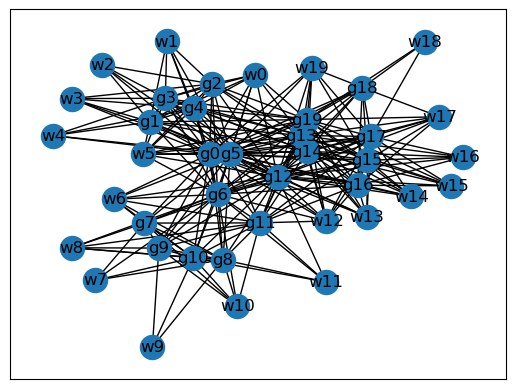

g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w


In [5]:
guards = solver.generate_guard_set(poly)
witnesses = solver.generate_witness_set(poly)
graph = solver.generate_visibility_graph(guards, witnesses)

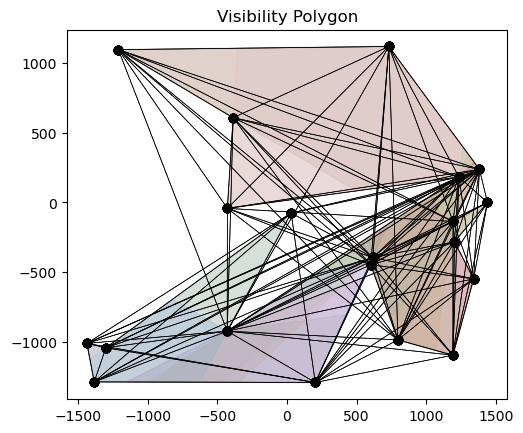

In [6]:
fig, ax = plt.subplots()
# plot_polygon(poly, ax=ax, color="lightgrey")

vis_poly_calc = VisibilityPolygonCalculator(poly)

vis_polygons = {}

for point in ring:
    vis_poly = vis_poly_calc.compute_visibility_polygon(point)
    plot_polygon(vis_poly, ax=ax, color=np.random.rand(3,), alpha=0.1)
    vis_polygons[(float(point.x()), float(point.y()))] = PolygonWithHoles(vis_poly)

keys = list(vis_polygons)
for point1 in keys:
    color = np.random.rand(3,)
    for point2 in keys:
        if point1 == point2:
            continue
        if not vis_polygons.get(point1).difference(vis_polygons.get(point2)):
            x, y = [point1[0], point2[0]], [point1[1], point2[1]]
            plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)
            continue
        if vis_polygons.get(point1).difference(vis_polygons.get(point2))[0].outer_boundary().area() < vis_polygons.get(point1).outer_boundary().area():
            x, y = [point1[0], point2[0]], [point1[1], point2[1]]
            plt.plot(x, y, marker = 'o', color='black', linewidth=0.5)

plt.rcParams['figure.dpi']=100
ax.set_aspect('equal')
plt.title("Visibility Polygon")
plt.show()
